好的，我来详细解释这个梯度传播链路的推导过程，让你彻底理解神经网络输出（Kp, Ki, Kd）是如何接收梯度的。核心是理解这个链式法则：

$$
d_loss/d_params = (d_loss/d_height) × (d_height/d_thrust) × (d_thrust/d_params)
$$

让我们一步步分解：

### 1. 损失函数对高度(height)的梯度
```python
d_loss_dheight = -2 * (target_height - height)
```
- **损失函数**：`loss = (target_height - height)²`
- **求导**：根据幂函数求导法则
  - `d(loss)/d(height) = 2 * (target_height - height) * (-1) = -2 * (target_height - height)`

### 2. 高度(height)对推力(thrust)的梯度
```python
d_height_dthrust = jacobian = dt**2 / (2 * mass)
```
- **物理模型**（基于牛顿运动定律）：
  ```
  加速度 a = (thrust - mg)/m
  速度变化 Δv = a × dt
  高度变化 Δh = v_avg × dt ≈ (v_initial + a×dt/2) × dt
  ```
- **高度关于推力的导数**：
  ```
  d(height)/d(thrust) = d(Δh)/d(thrust)
                      = d[(v_initial × dt + (a × dt²)/2)]/d(thrust)
                      = (dt²/2) × d(a)/d(thrust)
                      = (dt²/2) × (1/m)
  ```
- **推导要点**：
  - 推力直接影响加速度：`a = thrust/m - g`
  - 所以 `da/d(thrust) = 1/m`
  - 高度变化中与推力相关的部分：`Δh = ... + (1/2)(thrust/m)dt²`
  - 因此 `d(Δh)/d(thrust) = (dt²)/(2m)`

### 3. 推力(thrust)对PID参数的梯度
```python
# PID控制量计算：
thrust = Kp * error + Ki * integral_error + Kd * derivative_error

# 对Kp的梯度：
d_thrust_dKp = error

# 对Ki的梯度：
d_thrust_dKi = integral_error

# 对Kd的梯度：
d_thrust_dKd = derivative_error
```
- **直接偏导数计算**：
  - `∂(thrust)/∂(Kp) = error`
  - `∂(thrust)/∂(Ki) = integral_error = Σe`
  - `∂(thrust)/∂(Kd) = derivative_error = de/dt`

### 4. 组合梯度：损失对PID参数的梯度
```python
d_loss_dKp = d_loss_dheight * d_height_dthrust * d_thrust_dKp
d_loss_dKi = d_loss_dheight * d_height_dthrust * d_thrust_dKi
d_loss_dKd = d_loss_dheight * d_height_dthrust * d_thrust_dKd
```
- **链式法则应用**：
  ```
  d(loss)/d(Kp) = [d(loss)/d(height)] × [d(height)/d(thrust)] × [d(thrust)/d(Kp)]
  ```

### 5. 反向传播到神经网络
```python
# 获取神经网络输出节点
Kp_tensor, Ki_tensor, Kd_tensor = model(nn_input)

# 将计算出的梯度手动赋给输出节点
Kp_tensor.backward(gradient=torch.tensor(d_loss_dKp), retain_graph=True)
Ki_tensor.backward(gradient=torch.tensor(d_loss_dKi), retain_graph=True)
Kd_tensor.backward(gradient=torch.tensor(d_loss_dKd))
```
- **关键操作**：
  1. `backward(gradient=...)` 指定了该张量在反向传播中的"上游梯度"
  2. PyTorch会自动计算从该节点向下的梯度（即神经网络内部的权重梯度）
  3. `retain_graph=True` 保持计算图不被释放，以便多次反向传播

### 可视化梯度流
```
损失(loss) 
  ↓ d_loss/d_height
高度(height) 
  ↓ d_height/d_thrust
推力(thrust)
  ├─ d_thrust/d_Kp → Kp → 神经网络
  ├─ d_thrust/d_Ki → Ki → 神经网络
  └─ d_thrust/d_Kd → Kd → 神经网络
```

### 为什么需要手动梯度？
1. **非PyTorch操作**：物理仿真（高度计算）不是PyTorch操作
2. **断开计算图**：从`thrust`到`height`的计算在PyTorch计算图之外
3. **解决方案**：
   - 手动计算梯度（如上所示）
   - 或用PyTorch重写整个物理模型（更复杂但可自动微分）

### Jacobian的重要性
- **核心挑战**：`d_height/d_thrust`（系统Jacobian）通常未知
- **示例解决方案**：
  ```python
  # 近似方法1：简单物理模型（本例使用）
  jacobian = dt**2 / (2 * mass)
  
  # 近似方法2：数值差分（更通用）
  jacobian = (current_height - prev_height) / (current_thrust - prev_thrust)
  
  # 近似方法3：训练系统模型神经网络
  # （需要额外网络预测 d_height/d_thrust）
  ```

理解这个梯度链路是BP-PID的核心，虽然实现时需要处理Jacobian的近似问题，但基本原理就是这样的链式求导过程。

/var/folders/jx/hsm21jg10x574b3w9kt9p29w0000gn/T/ipykernel_4550/3911314960.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Kp_tensor.backward(gradient=torch.tensor(d_loss_dKp), retain_graph=True)
/var/folders/jx/hsm21jg10x574b3w9kt9p29w0000gn/T/ipykernel_4550/3911314960.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Ki_tensor.backward(gradient=torch.tensor(d_loss_dKi), retain_graph=True)
/var/folders/jx/hsm21jg10x574b3w9kt9p29w0000gn/T/ipykernel_4550/3911314960.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Kd_tensor.b

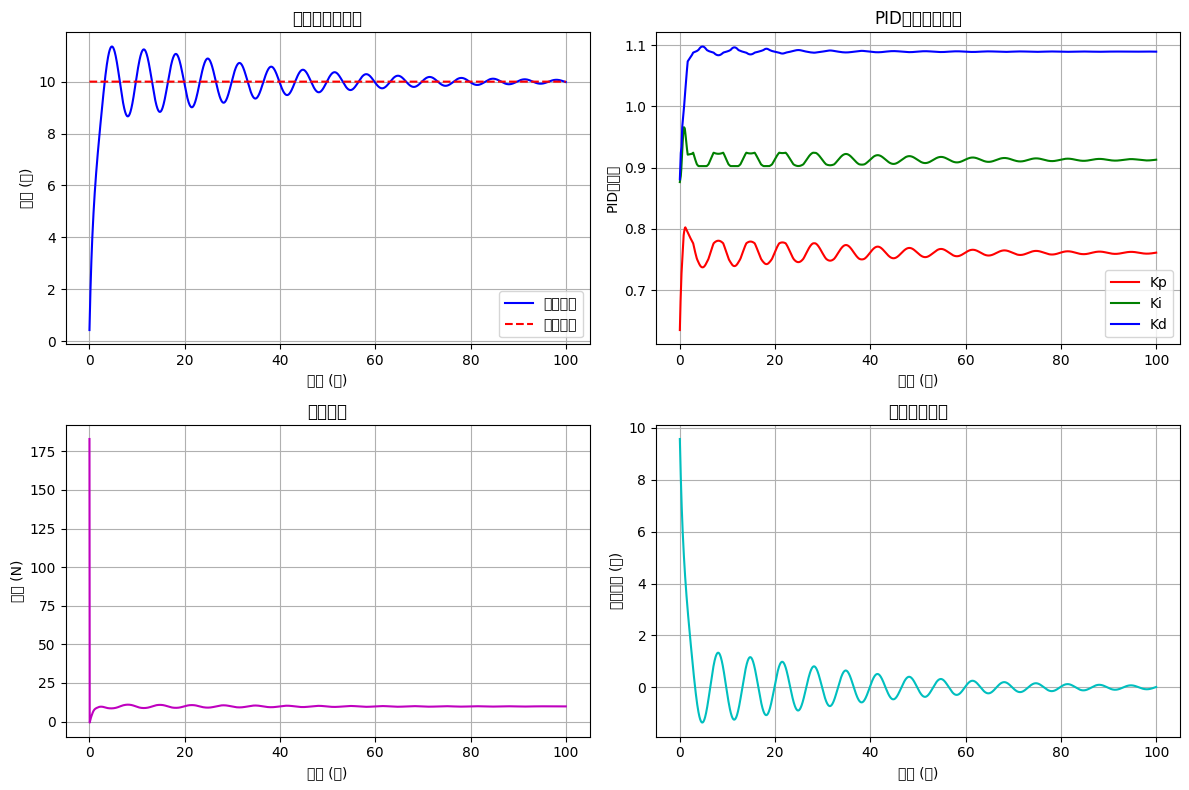

控制性能指标:
稳态误差: -0.0174 米
超调量: 1.3528 米
稳定时间: 3.20 秒


In [36]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 神经网络定义 (3层BP网络)
class PID_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, 16),  # 输入: [e_t, Δe_t, u_{t-1}]
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 3)    # 输出: [Kp, Ki, Kd]
        )
        # 确保PID参数为正
        # self.softplus = nn.Softplus()
        self.softplus = nn.Sigmoid()

    def forward(self, x):
        params = self.softplus(self.fc(x))
        params = 2 * params
        return params[0], params[1], params[2]  # Kp, Ki, Kd

# 初始化
model = PID_NN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-8)
target_height = 10.0  # 目标高度

# 无人机参数
mass = 1.0
g = 9.81
dt = 0.05  # 减小时间步长以提高精度
total_time = 100.0  # 总模拟时间
n_steps = int(total_time / dt)

# 记录数据
time_points = np.linspace(0, total_time, n_steps)
height_history = np.zeros(n_steps)
target_history = np.full(n_steps, target_height)
kp_history = np.zeros(n_steps)
ki_history = np.zeros(n_steps)
kd_history = np.zeros(n_steps)
thrust_history = np.zeros(n_steps)

# 初始状态
height = 0.0          # 初始高度
velocity = 0.0        # 初始速度
integral_error = 0.0  # 误差积分
prev_error = 0.0      # 上一时刻误差
prev_control = 0.0    # 上一时刻控制量

# 模拟循环
for step in range(n_steps):
    # 1. 计算当前误差
    error = target_height - height
    
    # 2. 神经网络生成PID参数
    nn_input = torch.tensor([target_height, height, error, 1], dtype=torch.float32)
    Kp, Ki, Kd = model(nn_input)
    
    # 3. PID计算控制量 (推力)
    integral_error += error * dt
    derivative_error = (error - prev_error) / dt
    thrust = Kp*error + Ki*integral_error + Kd*derivative_error
    
    # 4. 模拟无人机动力学
    net_force = thrust - mass * g
    acceleration = net_force / mass
    velocity += acceleration * dt
    height += velocity * dt
    
    # 5. 计算损失
    loss = (target_height - height) ** 2
    
    # 6. 反向传播
    optimizer.zero_grad()
    
    # 近似系统Jacobian (∂height/∂thrust)
    # 使用更精确的模型: d(height)/d(thrust) = dt^2 / mass
    jacobian = dt**2 / mass
    
    # 手动计算梯度
    d_loss_dheight = -2 * (target_height - height)
    d_height_dthrust = jacobian
    d_thrust_dKp = error
    d_thrust_dKi = integral_error
    d_thrust_dKd = derivative_error
    
    d_loss_dKp = d_loss_dheight * d_height_dthrust * d_thrust_dKp
    d_loss_dKi = d_loss_dheight * d_height_dthrust * d_thrust_dKi
    d_loss_dKd = d_loss_dheight * d_height_dthrust * d_thrust_dKd
    
    # 反向传播至神经网络
    Kp_tensor = model(nn_input)[0]
    Ki_tensor = model(nn_input)[1]
    Kd_tensor = model(nn_input)[2]
    
    Kp_tensor.backward(gradient=torch.tensor(d_loss_dKp), retain_graph=True)
    Ki_tensor.backward(gradient=torch.tensor(d_loss_dKi), retain_graph=True)
    Kd_tensor.backward(gradient=torch.tensor(d_loss_dKd))
    
    optimizer.step()
    
    # 7. 记录数据
    height_history[step] = height
    kp_history[step] = Kp.detach().numpy()
    ki_history[step] = Ki.detach().numpy()
    kd_history[step] = Kd.detach().numpy()
    thrust_history[step] = thrust.detach().numpy()
    
    # 8. 更新状态
    prev_error = error
    prev_control = thrust.item()

from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 绘制高度变化曲线
plt.figure(figsize=(12, 8))

# 高度变化曲线
plt.subplot(2, 2, 1)
plt.plot(time_points, height_history, 'b-', label='实际高度')
plt.plot(time_points, target_history, 'r--', label='目标高度')
plt.xlabel('时间 (秒)')
plt.ylabel('高度 (米)')
plt.title('无人机高度变化')
plt.legend()
plt.grid(True)

# PID参数变化曲线
plt.subplot(2, 2, 2)
plt.plot(time_points, kp_history, 'r-', label='Kp')
plt.plot(time_points, ki_history, 'g-', label='Ki')
plt.plot(time_points, kd_history, 'b-', label='Kd')
plt.xlabel('时间 (秒)')
plt.ylabel('PID参数值')
plt.title('PID参数动态调整')
plt.legend()
plt.grid(True)

# 推力变化曲线
plt.subplot(2, 2, 3)
plt.plot(time_points, thrust_history, 'm-')
plt.xlabel('时间 (秒)')
plt.ylabel('推力 (N)')
plt.title('推力变化')
plt.grid(True)

# 高度误差曲线
plt.subplot(2, 2, 4)
height_error = target_history - height_history
plt.plot(time_points, height_error, 'c-')
plt.xlabel('时间 (秒)')
plt.ylabel('高度误差 (米)')
plt.title('高度误差变化')
plt.grid(True)

plt.tight_layout()
plt.savefig('drone_height_control.png', dpi=300)
plt.show()

# 输出最终性能指标
steady_state_error = np.mean(height_error[-100:])  # 最后2秒的平均误差
overshoot = np.max(height_history) - target_height
settling_time_idx = np.where(np.abs(height_error) < 0.05)[0][0]  # 误差小于5cm的时间
settling_time = time_points[settling_time_idx]

print(f"控制性能指标:")
print(f"稳态误差: {steady_state_error:.4f} 米")
print(f"超调量: {overshoot:.4f} 米")
print(f"稳定时间: {settling_time:.2f} 秒")
